# **Running the BAO fit for a given dataset and settings**

This notebook shows how to run a BAO fit

In [1]:
%load_ext autoreload
%autoreload 2

CUDA backend failed to initialize: INTERNAL: no supported devices found for platform CUDA (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Averaging the w(theta) over 1952 mocks!
All theta values are the same. Using the first one as an array.
Fitted galaxy bias: ['bin 0: 1.650', 'bin 1: 1.544', 'bin 2: 1.614', 'bin 3: 1.785', 'bin 4: 2.038', 'bin 5: 2.441']
Averaging the w(theta) over 1952 mocks!
All theta values are the same. Using the first one as an array.
Saving output to: fit_results/COLAY6/mock_mean/nzCOLA_covcosmolike_micetemp_micecov_deltatheta0.2_thetamin0.5_thetamax5_3broadband_binsremoved[]_alphamin0.8_alphamax1.2
Best-fit alpha = 1.0062 ± 0.0182
chi2/dof = 0.1405/107


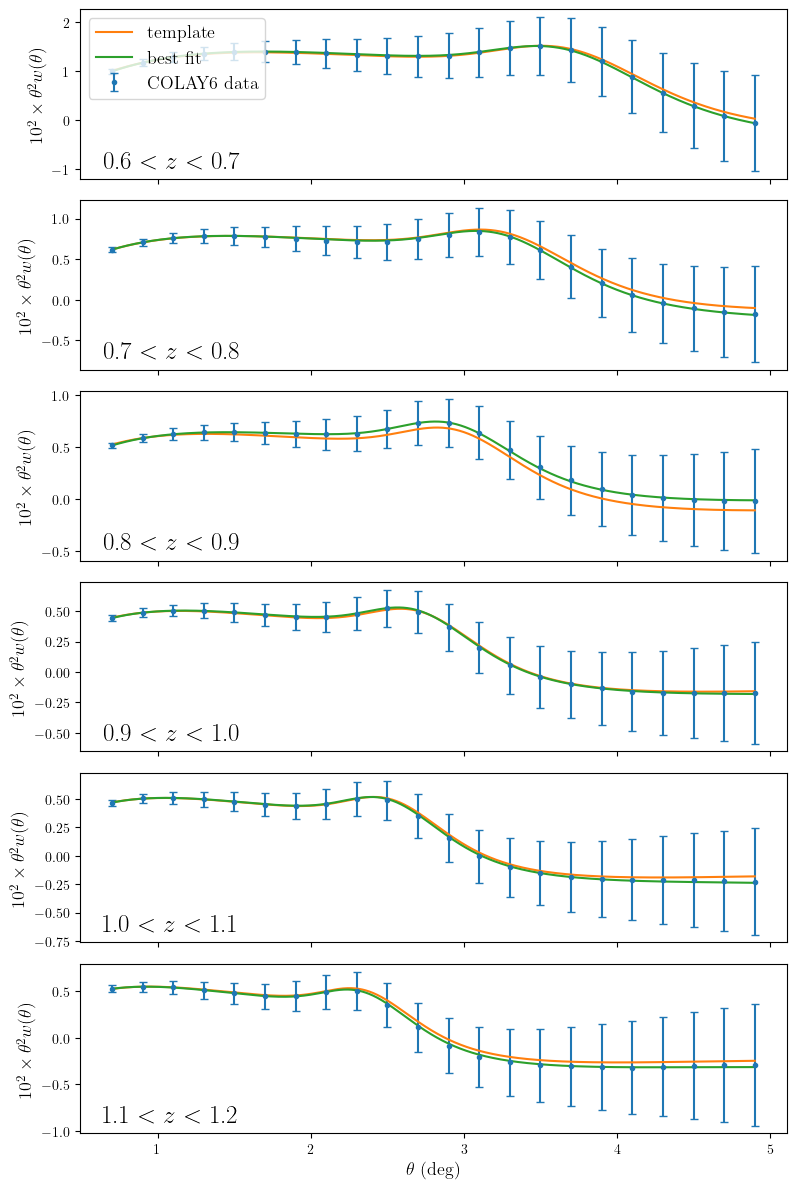

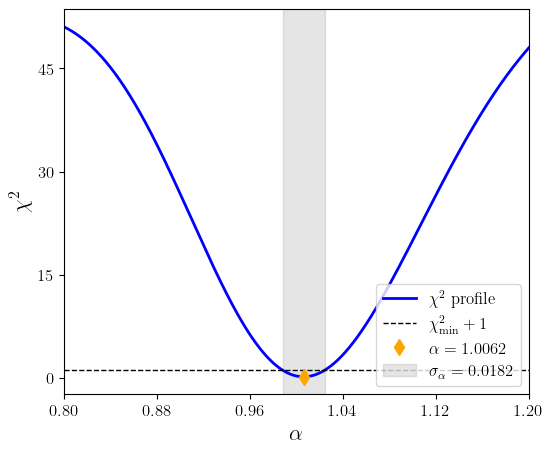

In [2]:
import numpy as np
import itertools
from scipy.optimize import curve_fit
from utils_data import RedshiftDistributions, WThetaDataCovariance
from utils_baofit import WThetaModelGalaxyBias, WThetaModel, BAOFitInitializer, BAOFit

# 1. Arguments
# class Args:
#     def __init__(self):
#         self.include_wiggles = "y"
#         self.dataset = "DESY6"
#         self.weight_type = 1
#         self.mock_id = "mean" # it will not be used...
#         self.nz_flag = "fid"
#         # self.nz_flag = "clusteringz"
#         self.cov_type = "cosmolike"
#         self.cosmology_template = "planck"
#         self.cosmology_covariance = "planck"
#         self.delta_theta = 0.2
#         self.theta_min = 0.5
#         self.theta_max = 5
#         self.n_broadband = 3
#         self.bins_removed = 'None'
#         self.diag_only = "n"
#         self.remove_crosscov = "n"
#         self.alpha_min = 0.8
#         self.alpha_max = 1.2
class Args:
    def __init__(self):
        self.include_wiggles = "y"
        self.dataset = "COLAY6"
        self.weight_type = 1 # it will not be used...
        self.mock_id = "mean"
        self.nz_flag = "COLA"
        self.cov_type = "cosmolike"
        self.cosmology_template = "mice"
        self.cosmology_covariance = "mice"
        self.delta_theta = 0.2
        self.theta_min = 0.5
        self.theta_max = 5
        self.n_broadband = 3
        self.bins_removed = 'None'
        self.diag_only = "n"
        self.remove_crosscov = "n"
        self.alpha_min = 0.8
        self.alpha_max = 1.2
args = Args()
args.include_wiggles = '' if args.include_wiggles == 'y' else '_nowiggles'

# 2. Post-process bins_removed
def _map_bins_removed(bins_removed):
    """Convert bins_removed string into corresponding bin combinations."""
    def generate_bin_mappings():
        bin_mappings = {'None': []}
        for i in range(1, 10):
            for combo in itertools.combinations(range(10), i):
                key = ''.join(map(str, combo))
                bin_mappings[key] = list(combo)
        return bin_mappings
    bin_mappings = generate_bin_mappings()
    return bin_mappings.get(bins_removed)
args.bins_removed = _map_bins_removed(args.bins_removed)

fit_galaxybias = True

if fit_galaxybias:
    # 3. Load data w(theta) and covariance (for the linear galaxy bias fit)
    wtheta_data_covariance = WThetaDataCovariance(
        dataset=args.dataset,
        weight_type=args.weight_type,
        mock_id="mean",
        nz_flag=args.nz_flag, # this is only needed to get nbins...
        cov_type=args.cov_type,
        cosmology_covariance=args.cosmology_covariance,
        delta_theta=args.delta_theta,
        theta_min=0.5,
        theta_max=2,
        bins_removed=args.bins_removed,
        diag_only='y',
        remove_crosscov=args.remove_crosscov,
    )
    theta_data, wtheta_data, cov = wtheta_data_covariance.process()
    nbins = len(wtheta_data)
    wtheta_data_concatenated = np.concatenate([wtheta_data[bin_z] for bin_z in range(nbins)])

    # 4. Get the model wtheta (for the linear galaxy bias fit)
    wtheta_model_galaxybias = WThetaModelGalaxyBias(
        include_wiggles=args.include_wiggles,
        dataset=args.dataset,
        nz_flag=args.nz_flag,
        cosmology_template=args.cosmology_template,
    )
    
    # 5. Fit the linear galaxy bias
    popt, pcov = curve_fit(wtheta_model_galaxybias.get_wtheta_function(), theta_data, wtheta_data_concatenated, np.ones(nbins), bounds=([0] * nbins, [3] * nbins), sigma=cov, absolute_sigma=False)
    galaxy_bias = {bin_z: popt[bin_z] for bin_z in range(len(popt))}
    
    print(f"Fitted galaxy bias: {[f'bin {bin_z}: {galaxy_bias[bin_z]:.3f}' for bin_z in range(len(galaxy_bias))]}")

else:
    galaxy_bias = {bin_z: 2 for bin_z in range(10)}
    
# 3. Load data w(theta) and covariance
wtheta_data_covariance = WThetaDataCovariance(
    dataset=args.dataset,
    weight_type=args.weight_type,
    mock_id=args.mock_id,
    nz_flag=args.nz_flag, # this is only needed to get nbins...
    cov_type=args.cov_type,
    cosmology_covariance=args.cosmology_covariance,
    delta_theta=args.delta_theta,
    theta_min=args.theta_min,
    theta_max=args.theta_max,
    bins_removed=args.bins_removed,
    diag_only=args.diag_only,
    remove_crosscov=args.remove_crosscov,
)
theta_data, wtheta_data, cov = wtheta_data_covariance.process()

# 4. Get the model wtheta
wtheta_model = WThetaModel(
    include_wiggles=args.include_wiggles,
    dataset=args.dataset,
    nz_flag=args.nz_flag,
    cosmology_template=args.cosmology_template,
    n_broadband=args.n_broadband,
    galaxy_bias=galaxy_bias, 
)

# 5. BAO fit initializer. This basically creates the path to save the results
baofit_initializer = BAOFitInitializer(
    include_wiggles=args.include_wiggles,
    dataset=args.dataset,
    weight_type=args.weight_type,
    mock_id=args.mock_id,
    nz_flag=args.nz_flag,
    cov_type=args.cov_type,
    cosmology_template=args.cosmology_template,
    cosmology_covariance=args.cosmology_covariance,
    delta_theta=args.delta_theta,
    theta_min=args.theta_min,
    theta_max=args.theta_max,
    n_broadband=args.n_broadband,
    bins_removed=args.bins_removed,
    alpha_min=args.alpha_min,
    alpha_max=args.alpha_max,
    verbose=True
)

# 6. Run the BAO fit
baofit = BAOFit(
    baofit_initializer=baofit_initializer,
    wtheta_model=wtheta_model,
    theta_data=theta_data,
    wtheta_data=wtheta_data,
    cov=cov,
    close_fig=False,
    use_multiprocessing=True,
    n_cpu=128
)
alpha_best, err_alpha, chi2_best, dof = baofit.fit()
